In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split
import numpy as np
import random
from sklearn.metrics import f1_score, recall_score
import matplotlib.pyplot as plt
import os
import json

In [5]:
# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"device: {device}")

device: cuda:0


In [6]:
# Download and load the CIFAR-10 dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_set = datasets.CIFAR10(root='../data', train=True, download=True, transform=transform)
test_set = datasets.CIFAR10(root='../data', train=False, download=True, transform=transform)

# Split train data into train and validation
train_size = int(0.8 * len(train_set))
val_size = len(train_set) - train_size
train_dataset, val_dataset = random_split(train_set, [train_size, val_size])

batch_size = 1024
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)

100.0%


Extracting ../data\cifar-10-python.tar.gz to ../data
Files already downloaded and verified


In [7]:
# Function to set a random seed for reproducibility
def set_seed(seed=None):
    if seed is None:
        seed = np.random.randint(0, 10000)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    return seed

In [8]:
# Function for validation
def validate(net, val_loader, criterion):
    total_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
    return total_loss / len(val_loader)

In [9]:
# Function to calculate test error
def calculate_test_error(net, test_loader):
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_accuracy = 100 * correct / total
    return 100 - test_accuracy  # Test error

In [10]:
# Function for training
def train_model(net, train_loader, val_loader, test_loader, criterion, optimizer, epochs):
    train_losses = []
    val_losses = []
    test_errors = []
    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)

            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        
        train_losses.append(running_loss / len(train_loader))
        val_loss = validate(net, val_loader, criterion)
        val_losses.append(val_loss)
        test_error = calculate_test_error(net, test_loader)
        test_errors.append(test_error)
        print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}, Test Error: {test_errors[-1]}')

    return train_losses, val_losses, test_errors

In [11]:
# Function to calculate accuracy, F1 score, and recall
def calculate_metrics(net, loader):
    net.eval()
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    
    with torch.no_grad():
        for data in loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    accuracy = 100 * correct / total
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')
    return accuracy, f1, recall

In [12]:
# ResNet-18 with SE block

# SE block
class SEBlock(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)


def initialize_model(device):
    net = models.resnet18(weights=None)
    num_features = net.fc.in_features

    # Adding an SE block
    net.avgpool = nn.Sequential(net.avgpool, SEBlock(num_features))

    # Adjusting for 10 classes in CIFAR-10
    net.fc = torch.nn.Linear(num_features, 10)
    net = net.to(device)

    return net

In [13]:
def initialize_loss_function():
    return nn.CrossEntropyLoss()

In [14]:
def initialize_optimizer(model_params):
    return optim.Adam(model_params, lr=0.001)

Run: 1
Seed: 9086
Epoch 1/200, Train Loss: 1.4519090145826339, Validation Loss: 1.226689350605011, Test Error: 46.36
Epoch 2/200, Train Loss: 2.30199248790741, Validation Loss: 1.861679768562317, Test Error: 68.93
Epoch 3/200, Train Loss: 1.6581657379865646, Validation Loss: 1.54307222366333, Test Error: 56.76
Epoch 4/200, Train Loss: 1.44611294567585, Validation Loss: 1.7614166498184205, Test Error: 60.85
Epoch 5/200, Train Loss: 1.3655878126621246, Validation Loss: 1.5663718819618224, Test Error: 56.05
Epoch 6/200, Train Loss: 1.3002015769481658, Validation Loss: 1.3046700954437256, Test Error: 47.46
Epoch 7/200, Train Loss: 1.1505557358264924, Validation Loss: 1.5320229887962342, Test Error: 50.54
Epoch 8/200, Train Loss: 1.1179023265838623, Validation Loss: 1.1049174308776855, Test Error: 39.39
Epoch 9/200, Train Loss: 0.987789936363697, Validation Loss: 1.115776264667511, Test Error: 39.6
Epoch 10/200, Train Loss: 0.9155651867389679, Validation Loss: 1.073817825317383, Test Error:

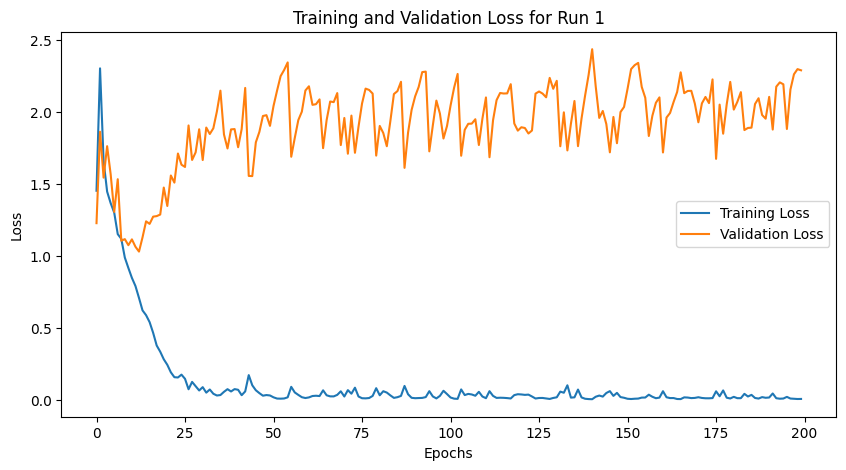

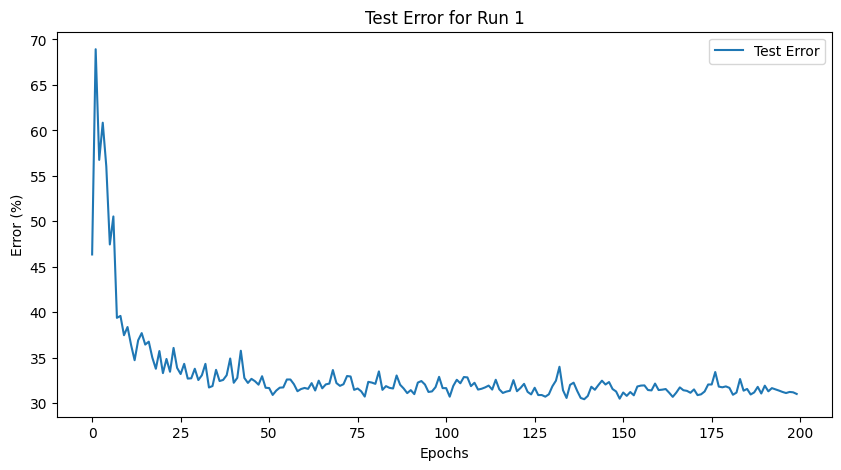

Run: 2
Seed: 1967
Epoch 1/200, Train Loss: 1.4733392685651778, Validation Loss: 1.2685468196868896, Test Error: 50.89
Epoch 2/200, Train Loss: 2.3081604450941087, Validation Loss: 1.8236069440841676, Test Error: 69.28999999999999
Epoch 3/200, Train Loss: 1.668558606505394, Validation Loss: 1.553888738155365, Test Error: 56.99
Epoch 4/200, Train Loss: 1.4943090558052063, Validation Loss: 1.5694266557693481, Test Error: 56.67
Epoch 5/200, Train Loss: 1.405683547258377, Validation Loss: 1.4021135807037353, Test Error: 50.51
Epoch 6/200, Train Loss: 1.2553245782852174, Validation Loss: 1.5172505855560303, Test Error: 53.05
Epoch 7/200, Train Loss: 1.2084182500839233, Validation Loss: 1.336681056022644, Test Error: 47.36
Epoch 8/200, Train Loss: 1.1179979249835015, Validation Loss: 1.191888165473938, Test Error: 42.31
Epoch 9/200, Train Loss: 1.0353464648127555, Validation Loss: 1.1504766821861268, Test Error: 41.03
Epoch 10/200, Train Loss: 0.949882087111473, Validation Loss: 1.08369042873

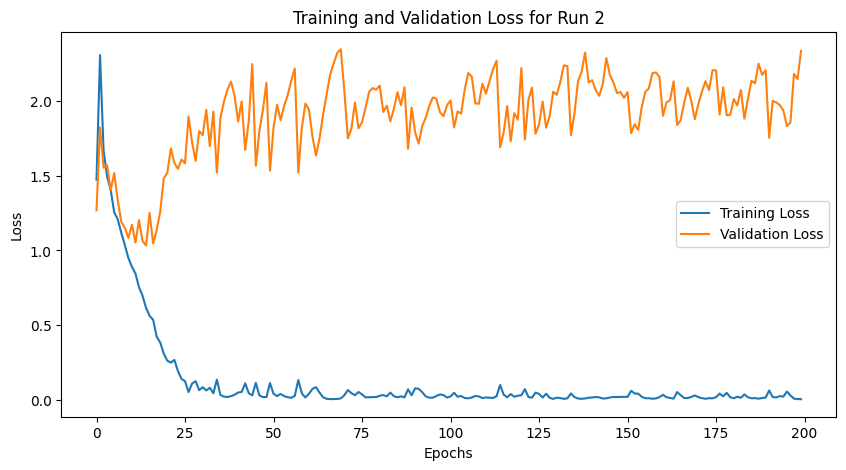

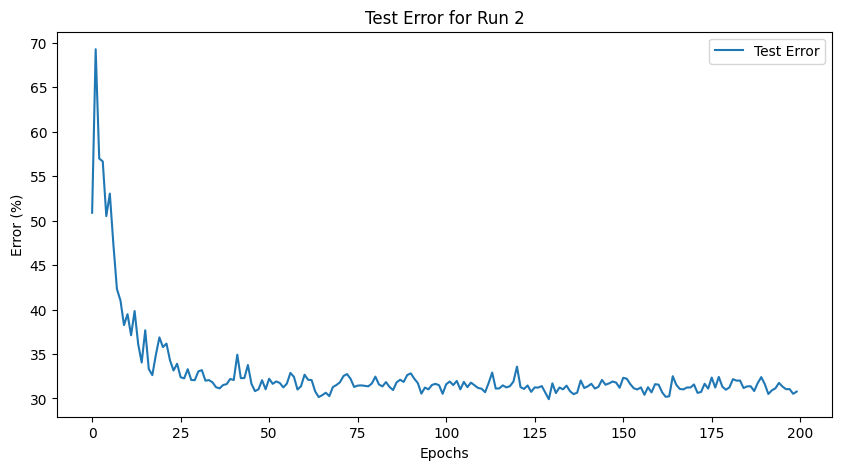

Run: 3
Seed: 2415
Epoch 1/200, Train Loss: 1.4832798779010772, Validation Loss: 1.2862728238105774, Test Error: 51.67
Epoch 2/200, Train Loss: 2.421310323476791, Validation Loss: 1.937286639213562, Test Error: 72.42
Epoch 3/200, Train Loss: 1.7265692979097367, Validation Loss: 1.667905044555664, Test Error: 61.15
Epoch 4/200, Train Loss: 1.518233421444893, Validation Loss: 1.6524415493011475, Test Error: 60.05
Epoch 5/200, Train Loss: 1.406797754764557, Validation Loss: 1.3946605324745178, Test Error: 50.39
Epoch 6/200, Train Loss: 1.2747501134872437, Validation Loss: 1.3616327404975892, Test Error: 49.83
Epoch 7/200, Train Loss: 1.1930832743644715, Validation Loss: 1.1778372406959534, Test Error: 42.63
Epoch 8/200, Train Loss: 1.1108291178941727, Validation Loss: 1.1728764176368713, Test Error: 41.95
Epoch 9/200, Train Loss: 1.0177293464541435, Validation Loss: 1.3977535367012024, Test Error: 48.56
Epoch 10/200, Train Loss: 0.9933935180306435, Validation Loss: 1.0720725893974303, Test

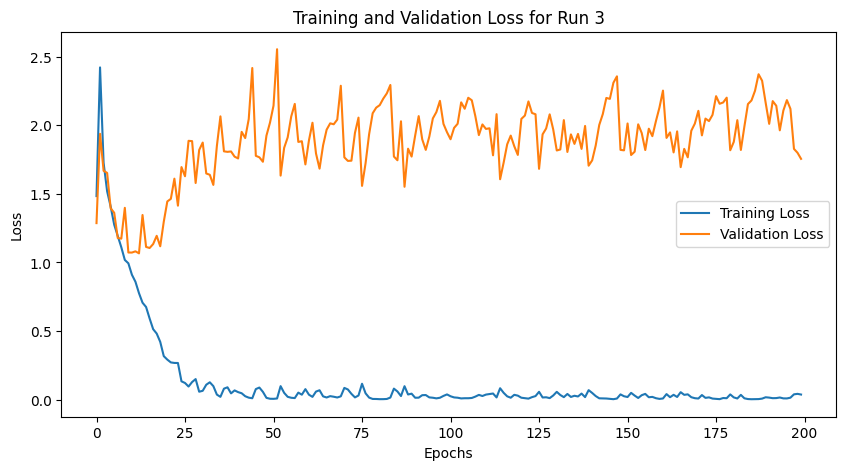

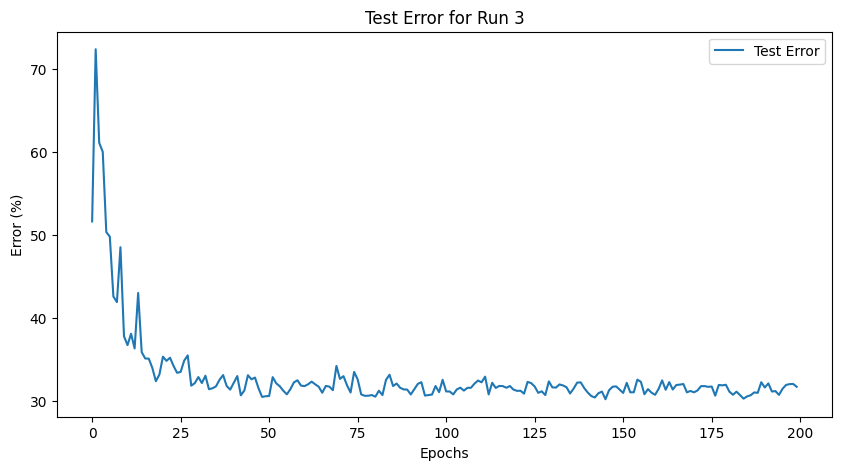

Run: 4
Seed: 865
Epoch 1/200, Train Loss: 1.497476077079773, Validation Loss: 1.3064641952514648, Test Error: 53.61
Epoch 2/200, Train Loss: 2.3865496814250946, Validation Loss: 1.7908724665641784, Test Error: 66.81
Epoch 3/200, Train Loss: 1.6784022510051728, Validation Loss: 1.6302041053771972, Test Error: 60.26
Epoch 4/200, Train Loss: 1.5077505081892013, Validation Loss: 1.4715282440185546, Test Error: 53.99
Epoch 5/200, Train Loss: 1.3727353394031525, Validation Loss: 1.6113861441612243, Test Error: 55.68
Epoch 6/200, Train Loss: 1.3083672791719436, Validation Loss: 1.3073432683944701, Test Error: 47.35
Epoch 7/200, Train Loss: 1.1692770570516586, Validation Loss: 1.4293832302093505, Test Error: 50.61
Epoch 8/200, Train Loss: 1.1192250549793243, Validation Loss: 1.1521816492080688, Test Error: 41.67
Epoch 9/200, Train Loss: 1.0181507974863053, Validation Loss: 1.1043967843055724, Test Error: 38.76
Epoch 10/200, Train Loss: 0.948797382414341, Validation Loss: 1.1699892044067384, Te

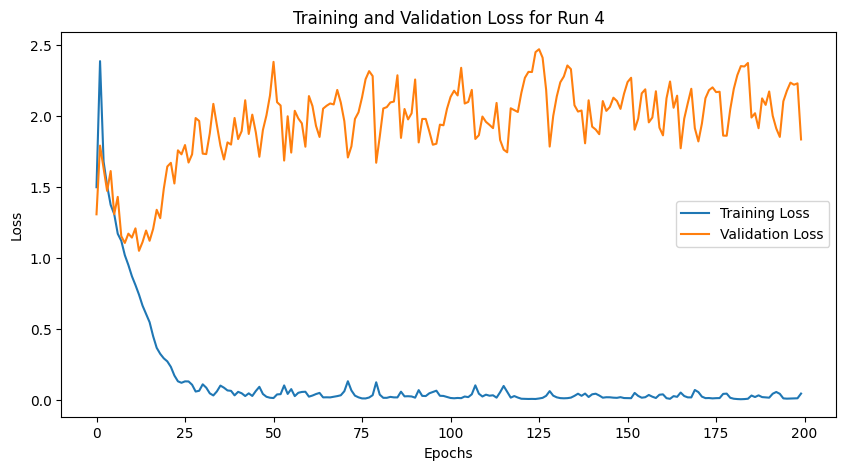

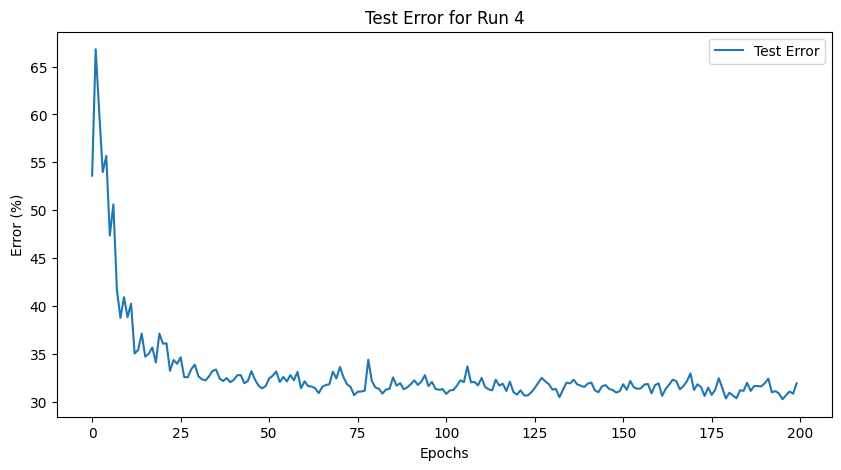

Run: 5
Seed: 7535
Epoch 1/200, Train Loss: 1.4921264976263047, Validation Loss: 1.237706184387207, Test Error: 45.76
Epoch 2/200, Train Loss: 2.3575283497571946, Validation Loss: 1.9148350715637208, Test Error: 74.97
Epoch 3/200, Train Loss: 1.7960123062133788, Validation Loss: 1.800578498840332, Test Error: 66.78999999999999
Epoch 4/200, Train Loss: 1.5665064066648484, Validation Loss: 1.5410512447357179, Test Error: 57.92
Epoch 5/200, Train Loss: 1.4086568146944045, Validation Loss: 1.3430517792701722, Test Error: 48.46
Epoch 6/200, Train Loss: 1.251922357082367, Validation Loss: 1.2694827914237976, Test Error: 46.04
Epoch 7/200, Train Loss: 1.1545262306928634, Validation Loss: 1.2057063579559326, Test Error: 42.51
Epoch 8/200, Train Loss: 1.0662976875901222, Validation Loss: 1.2766440033912658, Test Error: 45.55
Epoch 9/200, Train Loss: 1.031480149924755, Validation Loss: 1.1090885758399964, Test Error: 39.29
Epoch 10/200, Train Loss: 0.9435087248682976, Validation Loss: 1.101303339

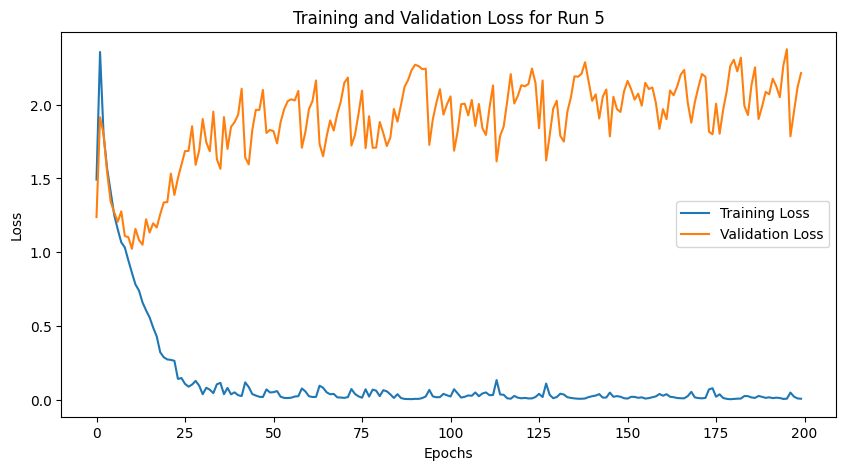

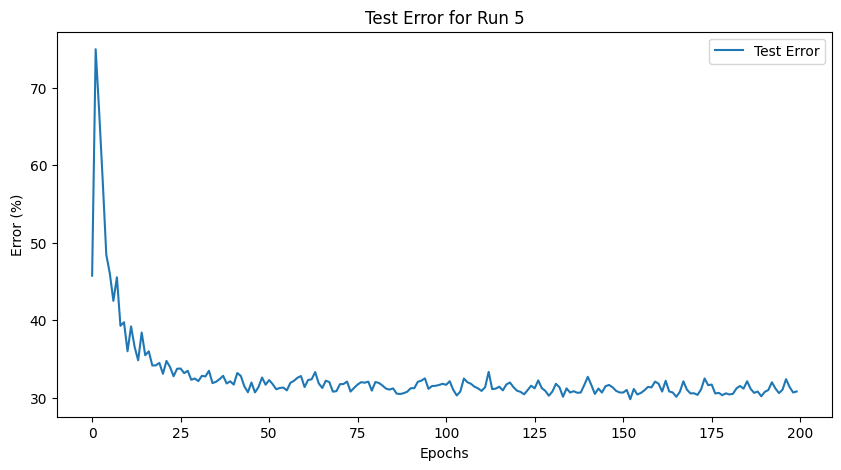

In [15]:
# Run the training for 5 different seeds
num_runs = 5
epochs = 200
metrics = {
    'seed': [],
    'train_losses': [],
    'val_losses': [],
    'test_errors': [],
    'val_accuracy': [],
    'val_f1': [],
    'val_recall': [],
    'test_accuracy': [],
    'test_f1': [],
    'test_recall': []
}



# Initialize dictionaries to store results
results = {
    'train_losses': [],
    'val_losses': [],
    'test_errors': []
}

for run in range(num_runs):
    print(f"Run: {run + 1}")
    seed = set_seed()
    print(f"Seed: {seed}")

    # Reinitialize the model, loss function, and optimizer
    net = initialize_model(device=device)
    criterion = initialize_loss_function()
    optimizer = initialize_optimizer(model_params=net.parameters())

    # Train the network
    train_losses, val_losses, test_errors = train_model(net, train_loader, val_loader, test_loader, criterion, optimizer, epochs)
    metrics['test_errors'].append(test_errors)

    # Calculate metrics on validation and test sets
    val_accuracy, val_f1, val_recall = calculate_metrics(net, val_loader)
    test_accuracy, test_f1, test_recall = calculate_metrics(net, test_loader)
    
    # Print metrics for validation set
    print(f"Run {run + 1} - Validation Metrics:")
    print(f"    Accuracy: {val_accuracy}%")
    print(f"    F1 Score: {val_f1}")
    print(f"    Recall:   {val_recall}")

    # Print metrics for test set
    print(f"Run {run + 1} - Test Metrics:")
    print(f"    Accuracy: {test_accuracy}%")
    print(f"    F1 Score: {test_f1}")
    print(f"    Recall:   {test_recall}")
    
    # Store metrics
    metrics['seed'].append(seed)
    metrics['train_losses'].append(train_losses)
    metrics['val_losses'].append(val_losses)
    metrics['val_accuracy'].append(val_accuracy)
    metrics['val_f1'].append(val_f1)
    metrics['val_recall'].append(val_recall)
    metrics['test_accuracy'].append(test_accuracy)
    metrics['test_f1'].append(test_f1)
    metrics['test_recall'].append(test_recall)
    
    # Append the results for the current run
    results['train_losses'].append(metrics['train_losses'][run])
    results['val_losses'].append(metrics['val_losses'][run])
    results['test_errors'].append(metrics['test_errors'][run])

    # Plot for training and validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(metrics['train_losses'][run], label='Training Loss')
    plt.plot(metrics['val_losses'][run], label='Validation Loss')
    plt.title(f"Training and Validation Loss for Run {run+1}")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plot for test error
    plt.figure(figsize=(10, 5))
    plt.plot(metrics['test_errors'][run], label='Test Error')
    plt.title(f"Test Error for Run {run+1}")
    plt.xlabel('Epochs')
    plt.ylabel('Error (%)')
    plt.legend()
    plt.show()

Mean Metrics: {'val_accuracy': 69.326, 'val_f1': 0.6935702481259995, 'val_recall': 0.6932600000000001, 'test_accuracy': 68.74199999999999, 'test_f1': 0.6872758483079895, 'test_recall': 0.68742}
Standard Deviation of Metrics: {'val_accuracy': 0.4403907355973789, 'val_f1': 0.003994316465252918, 'val_recall': 0.004403907355973806, 'test_accuracy': 0.4858559457287769, 'test_f1': 0.005125367977390174, 'test_recall': 0.004858559457287731}


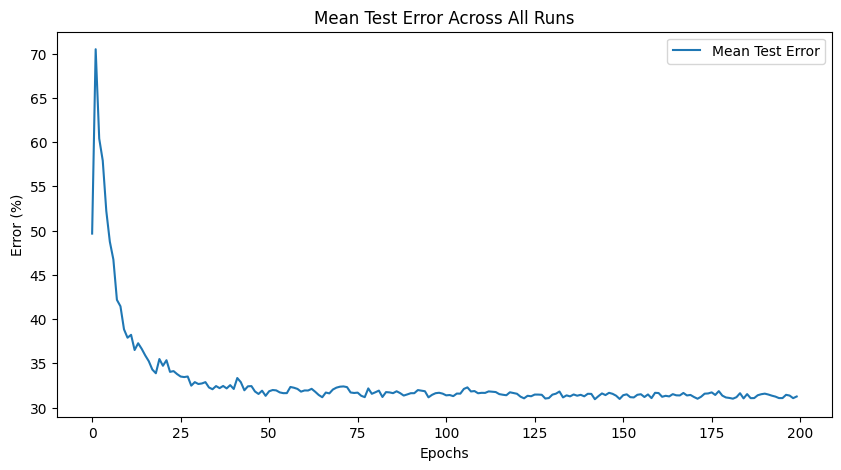

In [16]:
# Calculate mean and standard deviation across runs
mean_metrics = {metric: np.mean(metrics[metric]) for metric in metrics if metric not in ['seed', 'train_losses', 'val_losses', 'test_errors']}
std_metrics = {metric: np.std(metrics[metric]) for metric in metrics if metric not in ['seed', 'train_losses', 'val_losses', 'test_errors']}

# Print mean metrics and standard deviation
print("Mean Metrics:", mean_metrics)
print("Standard Deviation of Metrics:", std_metrics)

# Calculate mean test error across all runs
mean_test_errors = np.mean(metrics['test_errors'], axis=0)

# Plot mean test error
plt.figure(figsize=(10, 5))
plt.plot(mean_test_errors, label='Mean Test Error')
plt.title("Mean Test Error Across All Runs")
plt.xlabel('Epochs')
plt.ylabel('Error (%)')
plt.legend()
plt.show()

In [17]:
# Directory for saving results
save_dir = 'ResNet18_AL_Results'
os.makedirs(save_dir, exist_ok=True)

# Save the results to a file
with open(os.path.join(save_dir, 'ADAM.json'), 'w') as f:
    json.dump(results, f)